In [1]:
import sys
import os

ROOT_PATH = r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm'
FUNDUS_DATA_PATH = os.path.join(ROOT_PATH, r'assets\data\fundus')
BASE_LOG_PATH = os.path.join(ROOT_PATH, r'assets\model\SVIExperiment')
# BASE_LOG_PATH = os.path.join(ROOT_PATH, r'assets\model_sensitivity\SVIExperiment')
FIGURE_SAVE_PATH = r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm\assets\data\fundus\figures_ppt'

# Counterfactuals

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


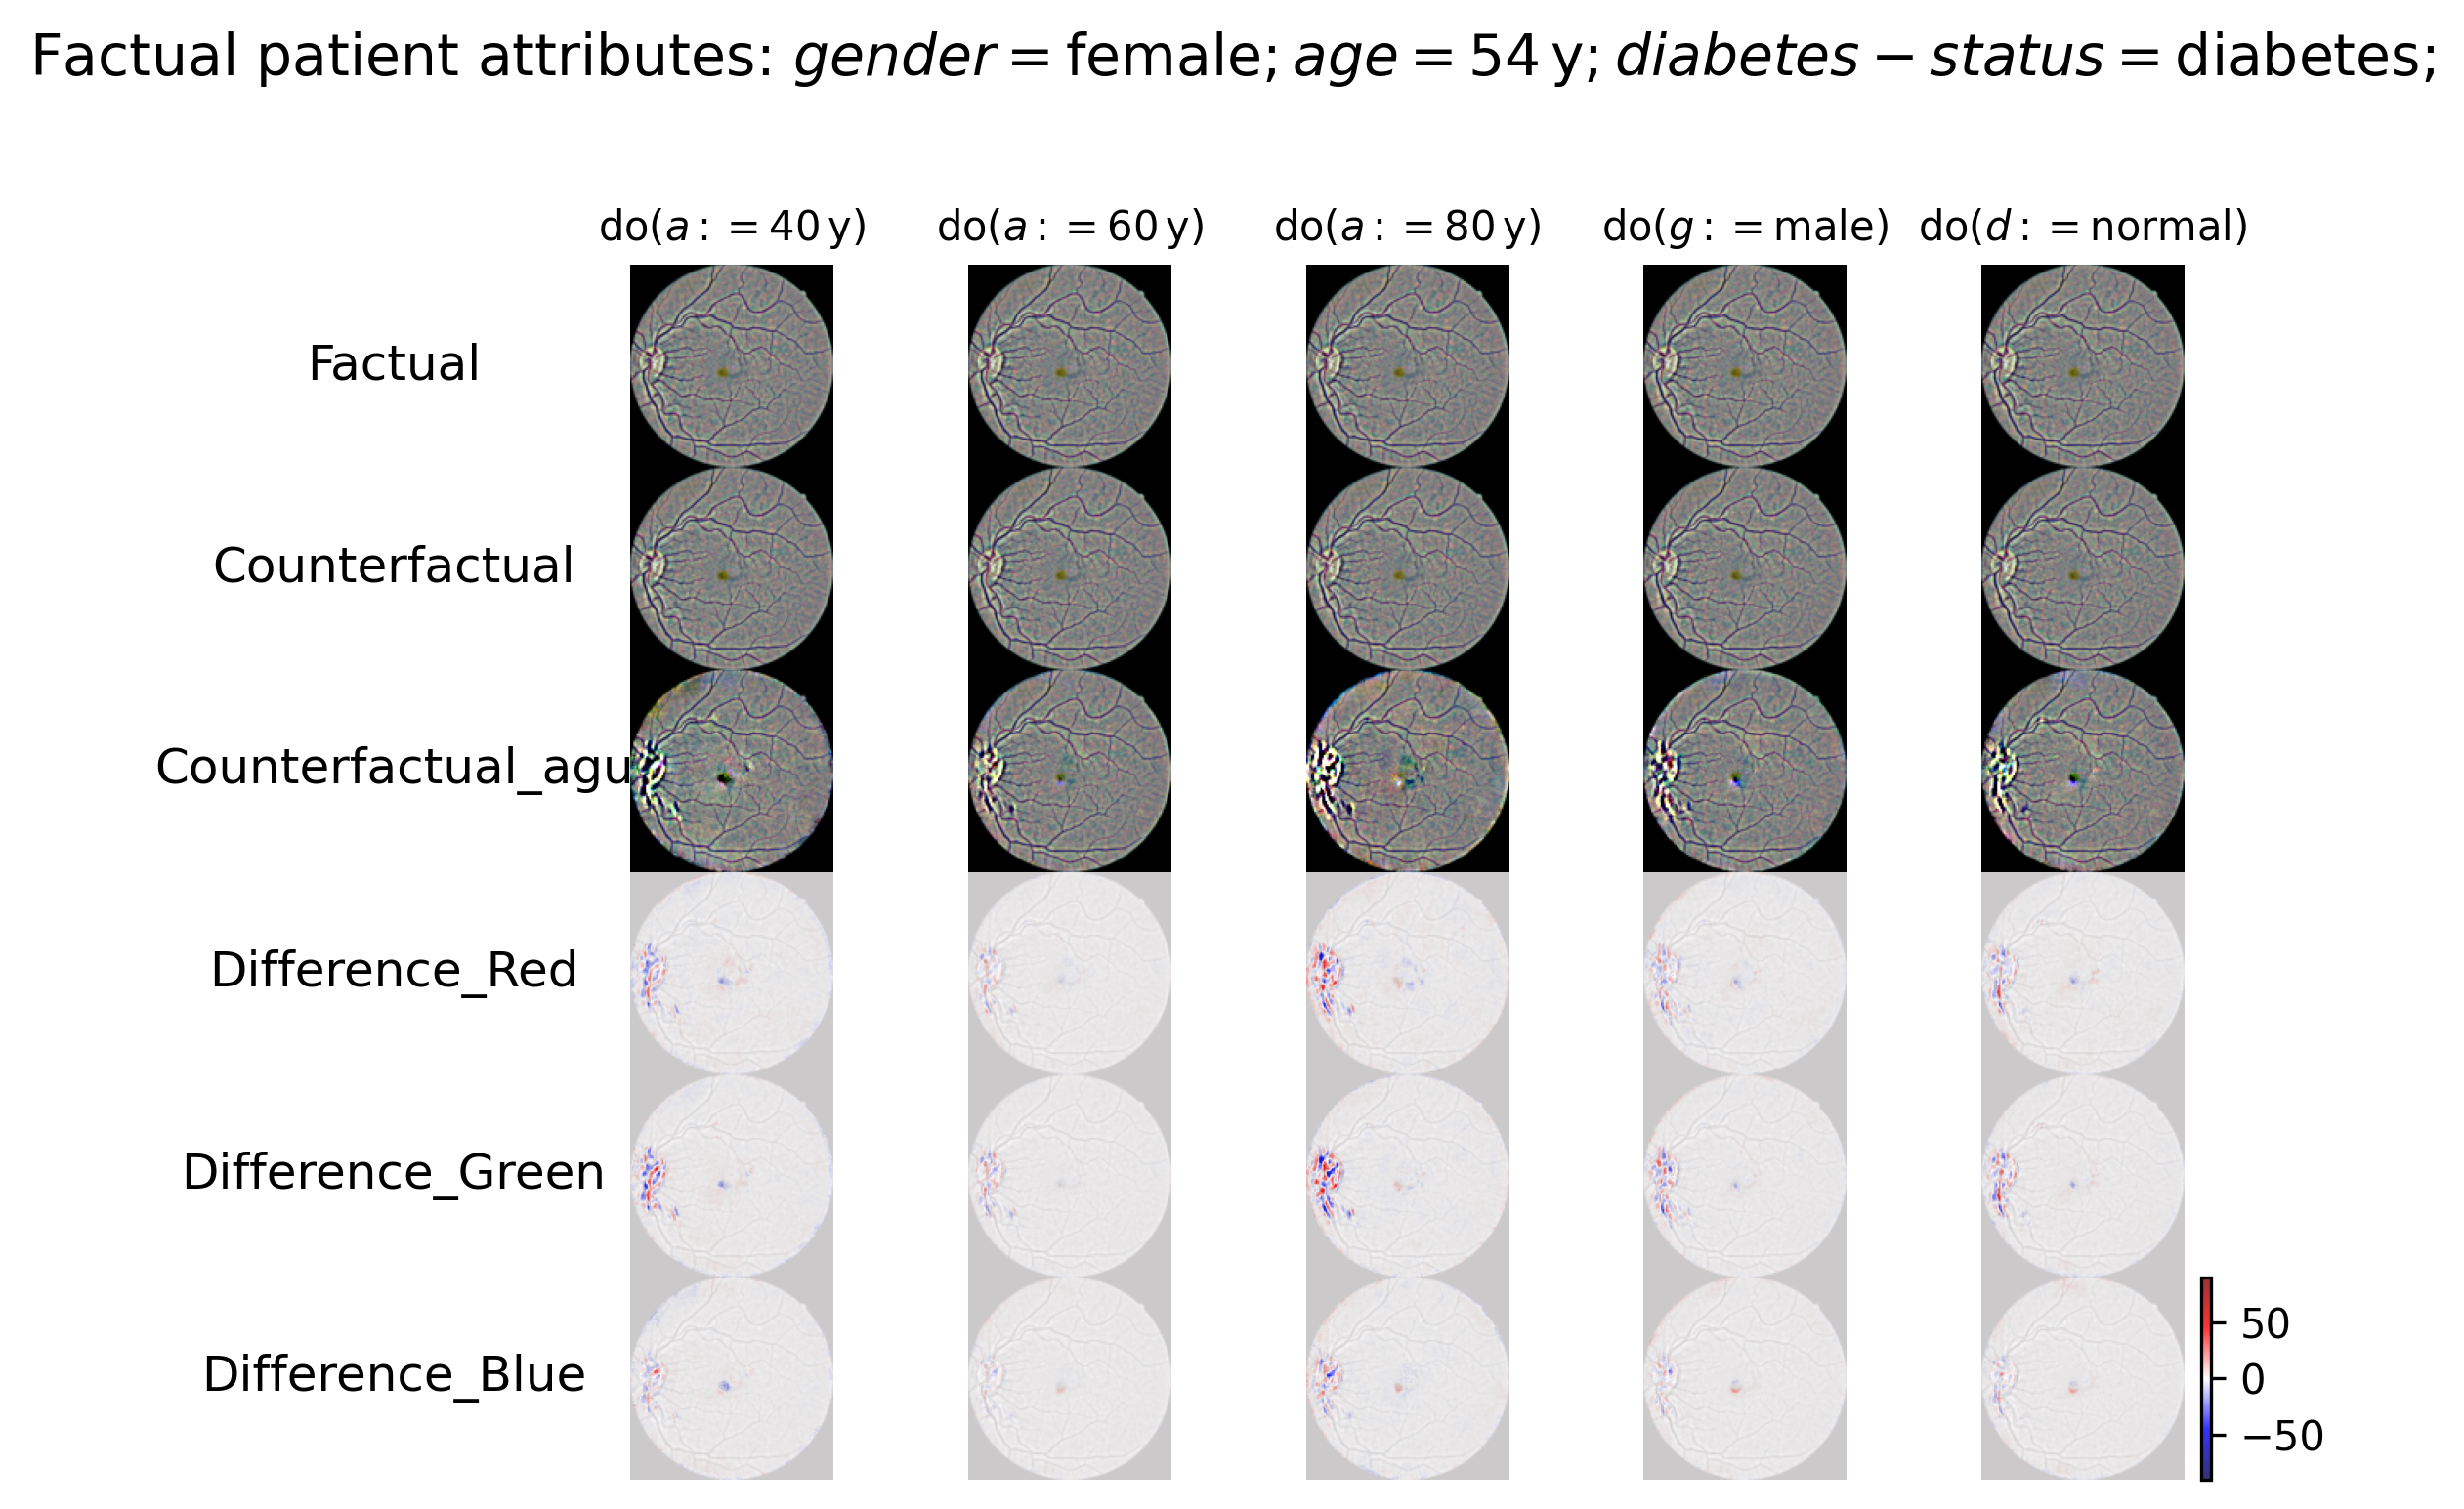

In [11]:
idx = 300
model_name = 'ConditionalVISEM'

interventions = [
    {'age': 40.},
    {'age': 60.},
    {'age': 80.},
    # {'sex': 0.},
    {'sex': 1.},
    {'T2D': 0.},
    # {'T2D': 1.},
]
#
# idx = 1963
# model_name = 'ConditionalVISEM'
#
# interventions = [
#     {'age': 40.},
#     {'age': 60.},
#     {'age': 80.},
#     {'sex': 0.},
#     # {'sex': 1.},
#     # {'T2D': 0.},
#     {'T2D': 1.},
# ]


m=plot_gen_intervention_range(model_name, interventions, idx, normalise_all=True, num_samples=32, agu=15)

# Counterfactual function

In [9]:
import sys
import os

ROOT_PATH = r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm'
FUNDUS_DATA_PATH = os.path.join(ROOT_PATH, r'assets\data\fundus')

sys.path.append(ROOT_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
version = 0

import pyro
import numpy as np
import matplotlib.pyplot as plt
import inspect
from collections import OrderedDict
from functools import partial
import torch
import traceback
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

from deepscm.datasets.fundus import fundusDataset

data_dir = f'{FUNDUS_DATA_PATH}/test2_features.xlsx'
base_path = f'{FUNDUS_DATA_PATH}/test2_image/'
downsample = 4
fundus_test = fundusDataset(data_dir, base_path=base_path, crop_type='center', downsample=downsample)

from deepscm.experiments.medical import fundus  # noqa: F401
from deepscm.experiments.medical.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

var_name = { 'T2D': 'd', 'sex': 'g', 'age': 'a'}
value_fmt = {
    'T2D': lambda s: '{}'.format(['\mathrm{normal}', '\mathrm{diabetes}'][int(s)]),
    'age': lambda s: rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['\mathrm{female}', '\mathrm{male}'][int(s)]),

}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        all_interventions = ',\n'.join([f'${var_name[k]}:={value_fmt[k](v)}$' for k, v in intervention.items()])
        return f"do({all_interventions})"

def prep_data(batch):

    x = batch['image'].cuda().unsqueeze(0)* 255.
    age = batch['age'].cuda().unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].cuda().unsqueeze(0).unsqueeze(0).float()
    T2D = batch['T2D'].cuda().unsqueeze(0).float()

    x = x.float()

    return {'x': x, 'age': age, 'sex': sex, 'T2D': T2D}

    x = batch['image'].cuda().unsqueeze(0)* 255.
    age = batch['age'].cuda().unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].cuda().unsqueeze(0).unsqueeze(0).float()
    T2D = batch['T2D'].cuda().unsqueeze(0).float()

    return {'x': x, 'age': age, 'sex': sex, 'waist': waist, \
            'smoking': smoking, 'HT': HT, 'bmi': bmi, 'T2D': T2D}
#
experiments = ['ConditionalVISEM']
models = {}
loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_{version}/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cuda'))
        hparams = ckpt['hyper_parameters']
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }

        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value

        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)

        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))

        loaded_model.eval()


        loaded_models[exp] = loaded_model

        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()

        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

def plot_gen_intervention_range(model_name, interventions, idx, normalise_all=True, num_samples=32, agu=10):
    fig, ax = plt.subplots(6, len(interventions)+1, figsize=(1.3 * (len(interventions)+1), 5), gridspec_kw=dict(wspace=0, hspace=0))
    lim = 0

    orig_data = prep_data(fundus_test[idx])

    imgs = []
    for intervention in interventions:
        pyro.clear_param_store()
        cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
        model = loaded_models[model_name].cuda()
        counterfactual = model.counterfactual(orig_data, cond, num_samples)

        imgs += [counterfactual['x']]

        diff = (imgs[-1].round().int()- orig_data['x'].round().int()).squeeze().cpu()

        lim = np.maximum(lim, diff.abs().max())

    row_labels=['Factual', 'Counterfactual', 'Counterfactual_agu', 'Difference_Red', 'Difference_Green', 'Difference_Blue']
    for row in range(6):
        ax[row, 0].text(0.5, 0.5, row_labels[row], horizontalalignment='center',
                                   verticalalignment='center', transform=ax[row, 0].transAxes,
                                   fontsize=mpl.rcParams['axes.titlesize'])
    for axi in ax[:, 0]:
        axi.axis('off')
        axi.xaxis.set_major_locator(plt.NullLocator())
        axi.yaxis.set_major_locator(plt.NullLocator())

    diffs=[]
    for i, intervention in enumerate(interventions):
        x = imgs[i].cpu().squeeze().permute(1,2,0).round().int()
        x_test = orig_data['x'].cpu().squeeze().permute(1,2,0).round().int()
        diff = (x - x_test)
        diffs.append(diff)
        if not normalise_all:
            lim = diff.abs().max()

        ax[0, i+1].imshow(x_test)

        ax[0, i+1].set_title(fmt_intervention(intervention), fontsize=10)
        ax[1, i+1].imshow(x)
        ax[2, i+1].imshow(diff * agu + x_test)
        ax[3, i+1].imshow((x_test/255.).mean(2), cmap='gist_gray')
        # ax[3, i+1].set_title('red_chan')
        ax[4, i+1].imshow((x_test/255.).mean(2), cmap='gist_gray')
        # ax[4, i + 1].set_title('green_chan')
        ax[5, i+1].imshow((x_test/255.).mean(2), cmap='gist_gray')
        # ax[5, i + 1].set_title('blue_chan')
        red_chan = ax[3, i+1].imshow(diff[:,:,0], cmap='seismic', clim=[-lim, lim], alpha=0.8)
        # plt.colorbar(red_chan)
        green_chan = ax[4, i+1].imshow(diff[:,:,1], cmap='seismic', clim=[-lim, lim], alpha=0.8)
        # plt.colorbar(green_chan)
        blue_chan = ax[5, i+1].imshow(diff[:,:,2], cmap='seismic', clim=[-lim, lim], alpha=0.8)
        # plt.colorbar(blue_chan)

        for axi in ax[:, i+1]:
            # if i ==0:
            #     break
            axi.axis('off')
            axi.xaxis.set_major_locator(plt.NullLocator())
            axi.yaxis.set_major_locator(plt.NullLocator())
    plt.colorbar(blue_chan)

    suptitle = 'Factual patient attributes: $gender={sex}; age={age}; diabetes-status={T2D};$'.format(
        **{att: value_fmt[att](orig_data[att].item()) for att in ('sex', 'age', 'T2D')}
    )
    fig.suptitle(suptitle, fontsize=14, y=1.02)

    fig.tight_layout()
    plt.savefig(f'{FIGURE_SAVE_PATH}/counterfactual_{idx}.png', bbox_inches='tight')
    plt.show()